<a href="https://colab.research.google.com/github/yingzibu/drug_design_JAK/blob/main/VAE/VAE_clean_08_06.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
! pip install -q torchview --quiet
! pip install -q -U graphviz --quiet
! pip install torchviz --quiet

  Preparing metadata (setup.py) ... done


In [13]:
from torchview import draw_graph
import torch
import graphviz
from __future__ import print_function
import argparse
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
import torch.distributions as td
from torch.distributions import Categorical, Normal, Bernoulli
import matplotlib.image as img
import matplotlib.pyplot as plt
import torchviz
import os
# when running on VSCode run the below command
# svg format on vscode does not give desired result
graphviz.set_jupyter_format('png')

'svg'

In [ ]:
batch_size = 128
device = 'cuda'
kwargs = {'num_workers': 1, 'pin_memory': True}

train_loader = torch.utils.data.DataLoader(datasets.MNIST('../data',
    train=True, download=True, transform=transforms.ToTensor()),
                 batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True, **kwargs)

In [15]:
def loss_func(recon_x, x):
    BCE = F.binary_cross_entropy(recon_x.cuda(),
                                 x.view(-1, 784).cuda(),
                                 reduction='sum')
    return BCE

In [27]:
def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x.cuda(),
                                 x.view(-1, 784).cuda(),
                                 reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

def plot_loss(train_list, test_list, title=None):
    print(train_list, type(train_list))
    print(test_list, type(test_list))
    assert len(train_list) == len(test_list)
    l = len(train_list)
    plt.figure()
    plt.plot(range(1, l+1), train_list, label = "train")
    plt.plot(range(1, l+1), test_list, label = "test")
    plt.xlabel('epoch')
    plt.ylabel('loss')
    if title != None:
        plt.title(title)
    plt.legend()
    plt.show()

In [28]:
class AE(nn.Module):
    def __init__(self, in_dim, out_dim, hidden_dim=20, hid_1=400):
        super(AE, self).__init__()
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.hidden_dim = hidden_dim
        self.fc1 = nn.Linear(in_dim, hid_1)
        self.fc2 = nn.Linear(hid_1, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, hid_1)
        self.fc4 = nn.Linear(hid_1, out_dim)
    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc2(h1)
    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))
    def forward(self, x):
        z = self.encode(x.view(-1, self.in_dim))
        recon_x = self.decode(z)
        return recon_x

class VAE(nn.Module):
    def __init__(self, in_dim, out_dim, hidden_dim=20, hid_1=400):
        super(VAE, self).__init__()
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.hidden_dim = hidden_dim
        super(VAE, self).__init__()
        self.fc1 = nn.Linear(in_dim, hid_1)
        self.fc21 = nn.Linear(hid_1, hidden_dim)
        self.fc22 = nn.Linear(hid_1, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, hid_1)
        self.fc4 = nn.Linear(hid_1, out_dim)
    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)
    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))
    def reparameterize(self, mu, logvar):
        std = logvar.exp().pow(0.5)
        eps = torch.randn_like(std)
        # eps * std is element wise multiplication between vectors
        return mu + eps * std
    def forward(self, x):
        mu, logvar = self.encode(x.view(-1,self.in_dim))
        z = self.reparameterize(mu, logvar)
        recon_x = self.decode(z)
        return recon_x, mu, logvar

class deepVAE(nn.Module):
    def __init__(self, in_dim, out_dim, hidden_dim=20,
                 hid_1=256*2, hid_2=256, hid_3=128):
        super(deepVAE, self).__init__()
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.hidden_dim = hidden_dim

        self.fc1 = nn.Linear(in_dim, hid_1)
        self.fc2 = nn.Linear(hid_1, hid_2)
        self.fc3 = nn.Linear(hid_2, hid_3)
        self.fc41 = nn.Linear(hid_3, hidden_dim)
        self.fc42 = nn.Linear(hid_3, hidden_dim)
        self.fc5 = nn.Linear(hidden_dim, hid_3)
        self.fc6 = nn.Linear(hid_3, hid_2)
        self.fc7 = nn.Linear(hid_2, hid_1)
        self.fc8 = nn.Linear(hid_1, out_dim)
    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        h1 = F.relu(self.fc2(h1))
        h1 = F.relu(self.fc3(h1))
        return self.fc41(h1), self.fc42(h1)
    def decode(self, z):
        h3 = F.relu(self.fc5(z))
        h3 = F.relu(self.fc6(h3))
        h3 = F.relu(self.fc7(h3))
        return torch.sigmoid(self.fc8(h3))
    def reparameterize(self, mu, logvar):
        std = logvar.exp().pow(0.5)
        eps = torch.randn_like(std)
        # eps * std is element wise multiplication between vectors
        return mu + eps * std
    def forward(self, x):
        mu, logvar = self.encode(x.view(-1,self.in_dim))
        z = self.reparameterize(mu, logvar)
        recon_x = self.decode(z)
        return recon_x, mu, logvar

# optimizer = optim.Adam(model.parameters(), lr=1e-3)
class MODEL:
    def __init__(self, model, optimizer, loss_function=loss_function,
                 train_loader=train_loader, test_loader=test_loader):
        super(MODEL, self).__init__()
        self.model = model
        self.loss_function = loss_function
        self.train_loader = train_loader
        self.test_loader = test_loader
        self.optimizer = optimizer

    def get_model(self):
        return self.model


    def train(self, epoch, log_interval=100, print_info=True):
        self.model.train()
        train_loss = 0
        for i, (data, _) in enumerate(self.train_loader):
            data = data.to(device)
            self.optimizer.zero_grad()
            try:
                recon_batch, mu, logvar = self.model(data)
                loss = self.loss_function(recon_batch, data, mu, logvar)
            except:
                recon_batch = self.model(data)
                loss = self.loss_function(recon_batch, data)
            loss.backward()
            train_loss += loss.item()
            self.optimizer.step()
            if i % log_interval == 0 and print_info == True:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, i * len(data), len(train_loader.dataset),
                100. * i / len(train_loader),
                loss.item() / len(data)))
        train_loss /= len(train_loader.dataset)
        if print_info == True:
            print('====> Epoch: {} Average loss: {:.4f}'.format(
                                epoch, train_loss))
        return train_loss

    def test(self, epoch, save_path=None, print_info=True):
        self.model.eval()
        if save_path != None:
            if not os.path.exists(save_path): os.mkdir(save_path)
        test_loss = 0
        for i, (data, _) in enumerate(self.test_loader):
            data = data.to(device)
            try:
                recon_batch, mu, logvar = self.model(data)
                test_loss += self.loss_function(
                recon_batch, data, mu, logvar).item()
            except:
                recon_batch = self.model(data)
                test_loss += self.loss_function(recon_batch, data).item()
            if i == 0:
                n = min(data.size(0), 8)
                comparison = torch.cat([data[:n],
                                       recon_batch.view(-1, 1, 28, 28)[:n]])
                save_image(comparison.cpu(),
                save_path+'recon_' + str(epoch) + '.png', nrow=n)

        test_loss /= len(self.test_loader.dataset)
        if print_info:
            print('====> Test set loss: {:.4f}'.format(test_loss))
        return test_loss

# record the train, test loss list during training epochs, plotting purpose
def train_test_loss(model, save_path,
                    epochs=100, plot_loss=5, print_info=False,
                    sample_img=True, show_img=True):
    print(f'\nwill train {epochs} epochs')
    print(f'will plot loss every {plot_loss} epochs')
    if save_path != None:
        if not os.path.exists(save_path): os.mkdir(save_path)
        print('sample fig will be saved at: ', save_path, '\n')

    hidden_dim = model.get_model().hidden_dim
    train_loss_list = []
    test_loss_list = []
    for epoch in range(1, epochs+1):
        train_loss = model.train(epoch, 200, print_info=print_info)
        test_loss = model.test(epoch, print_info=True, save_path=save_path)
        train_loss_list.append(train_loss)
        test_loss_list.append(test_loss)
        # print(train_loss_list, test_loss_list)

        # early stop
        if len(test_loss_list) - np.argmin(test_loss_list) > 10:
            print(f'no improvement after epoch{1+np.argmin(test_loss_list)}')
            print(f'min loss={np.min(test_loss_list)}')
            break
        if test_loss / np.min(test_loss_list) > 1.5:
            print(f'loss increase!')
            break

        with torch.no_grad():
            if epoch % plot_loss == 0:
                print('*'* 20, f'epoch={epoch}', '*'* 20)
                if sample_img:
                    sample = torch.randn(64,hidden_dim).to(device)
                    sample = model.get_model().decode(sample).cpu()
                    save_img_name = save_path + 'sample_'+str(epoch)+'.png'
                    save_image(sample.view(64, 1, 28, 28), save_img_name)
                    if show_img:
                        plt.imshow(img.imread(save_img_name))
    return train_loss_list, test_loss_list

In [18]:
model_AE = AE(in_dim=784, out_dim=784).to(device)
optimizer = optim.Adam(model_AE.parameters(), lr=1e-3)
AE_model = MODEL(model_AE, optimizer, loss_function=loss_func)
AE_trs, AE_tes = train_test_loss(AE_model, save_path='test_AE/',
        epochs=100, plot_loss=5, print_info=False, show_img=True, sample=False)


will train 100 epochs
will plot loss every 5 epochs
sample fig will be saved at:  test_AE/ 

====> Test set loss: 88.5759
====> Test set loss: 77.7680
====> Test set loss: 74.5389
====> Test set loss: 72.4874
====> Test set loss: 71.3542
******************** epoch=5 ********************
====> Test set loss: 70.2422
====> Test set loss: 69.4300
====> Test set loss: 68.9590
====> Test set loss: 68.6312
====> Test set loss: 68.0526
******************** epoch=10 ********************
====> Test set loss: 67.8145
====> Test set loss: 67.3333
====> Test set loss: 67.1007
====> Test set loss: 66.9481
====> Test set loss: 66.7001
******************** epoch=15 ********************
====> Test set loss: 66.4460
====> Test set loss: 66.4388
====> Test set loss: 66.2570
====> Test set loss: 66.1191
====> Test set loss: 66.0513
******************** epoch=20 ********************
====> Test set loss: 65.8742
====> Test set loss: 65.8901
====> Test set loss: 65.6229
====> Test set loss: 65.5180
====> T

[130.96444814453125, 83.00534760742187, 76.88832888997396, 74.17108033854167, 72.4250446126302, 71.16908553059896, 70.19235037434896, 69.44357535807292, 68.81710166829427, 68.2979522705078, 67.8492491373698, 67.47171577148437, 67.1523047281901, 66.83730223795573, 66.587633984375, 66.34226600748698, 66.14478927408854, 65.92280600585937, 65.75453349609376, 65.6061096516927, 65.44094245605469, 65.31024202473958, 65.16514152832032, 65.03963662109375, 64.9459044921875, 64.83517162272135, 64.73727596842448, 64.63790419921875, 64.55107919108073, 64.46980762532552, 64.37776479492187, 64.31901581217448, 64.24769793294271, 64.17235924479166, 64.10825034993489, 64.04863700358072, 63.98209230143229, 63.926878751627605, 63.878131754557295, 63.82969797363281, 63.77479782714844, 63.73320822753906, 63.67740384114583, 63.64032202148437, 63.590884448242186, 63.540858341471356, 63.52648188476562, 63.47640750325521, 63.43266478678385, 63.40057559407552, 63.3512218343099, 63.33746629231771, 63.302281412760

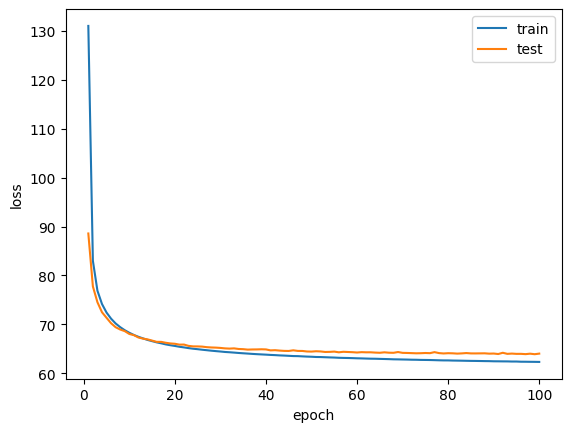

In [19]:
plot_loss(AE_trs, AE_tes)

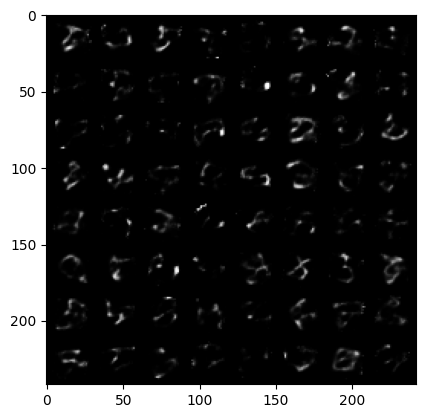

In [24]:
# AE_model.get_model()
# plot_loss(AE_trs, AE_tes)
sample = torch.randn(64,20).to(device)
sample = AE_model.get_model().decode(sample).cpu()
save_img_name = 'AE_sample.png'
save_image(sample.view(64, 1, 28, 28), save_img_name)

plt.imshow(img.imread(save_img_name))

In [29]:
model = VAE(in_dim=784, out_dim=784).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
VAE_model = MODEL(model, optimizer)
trs, tes = train_test_loss(VAE_model, save_path='test/',
        epochs=100, plot_loss=5, print_info=False, show_img=False)


will train 100 epochs
will plot loss every 5 epochs
sample fig will be saved at:  test/ 

====> Test set loss: 127.0746
====> Test set loss: 115.4473
====> Test set loss: 111.3940
====> Test set loss: 109.6667
====> Test set loss: 108.2835
******************** epoch=5 ********************
====> Test set loss: 107.6334
====> Test set loss: 106.7764
====> Test set loss: 106.0876
====> Test set loss: 105.8835
====> Test set loss: 105.5321
******************** epoch=10 ********************
====> Test set loss: 105.0617
====> Test set loss: 105.0417
====> Test set loss: 104.8485
====> Test set loss: 104.5393
====> Test set loss: 104.4484
******************** epoch=15 ********************
====> Test set loss: 104.1351
====> Test set loss: 104.1132
====> Test set loss: 103.9429
====> Test set loss: 103.7969
====> Test set loss: 103.7363
******************** epoch=20 ********************
====> Test set loss: 103.7043
====> Test set loss: 103.6608
====> Test set loss: 103.3850
====> Test set l

[164.23263354492187, 121.30600532226562, 114.45132731119791, 111.38929749348958, 109.67591049804687, 108.48063616536459, 107.64557862955729, 107.07247978515625, 106.5070279296875, 106.11781326497396, 105.7448951985677, 105.47554692382812, 105.18992467447917, 104.95278520507813, 104.76147962239584, 104.61654912109375, 104.41018639322917, 104.24742041015625, 104.08465651041666, 103.97174230143229, 103.81420166015624, 103.68896510416667, 103.59716271158854, 103.44476852213542, 103.31160517578125, 103.23465942382812, 103.15363933919271, 103.08539498697917, 103.02601199544272, 102.93475836588541, 102.81050364583334, 102.76152216796875, 102.67971041666667, 102.61638273111978, 102.6268616048177, 102.49279897460937, 102.42946116536459, 102.39563128255209, 102.27737516276042, 102.22320651041667, 102.19453977864583, 102.14871267903646, 102.1001796875, 102.05006077473958, 101.998130859375, 101.96919321289063, 101.9250114095052, 101.88664656575521, 101.81023662109375, 101.77845673828125, 101.74343

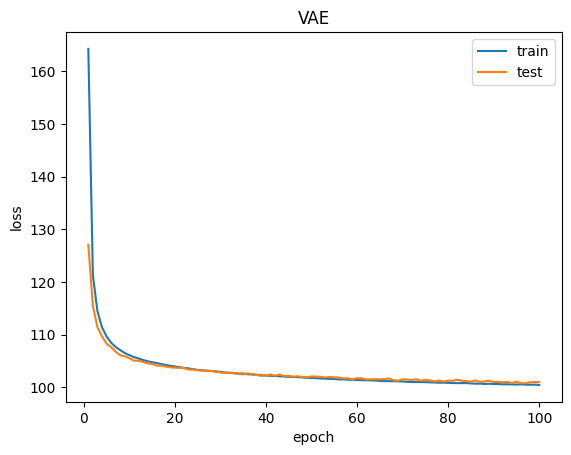

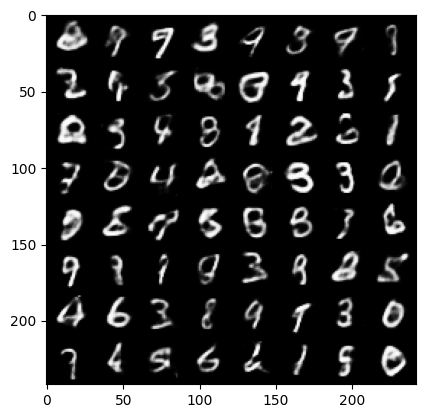

In [31]:
plot_loss(trs, tes, title='VAE')
sample = torch.randn(64,20).to(device)
sample = VAE_model.get_model().decode(sample).cpu()
save_img_name = 'VAE_sample.png'
save_image(sample.view(64, 1, 28, 28), save_img_name)

plt.imshow(img.imread(save_img_name))

In [114]:
# import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn.preprocessing import StandardScaler

AE_m = AE_model.get_model()
AE_m.eval()
zs_AE = torch.Tensor().cuda()
labels_AE = torch.Tensor().cuda()

for i, (data, label) in enumerate(test_loader):
    data = data.to(device)
    label = label.to(device)
    mu = AE_m.encode(data.view(-1,784))
    zs_AE = torch.cat((zs_AE, mu), 0)
    labels_AE = torch.cat((labels_AE, label), 0)

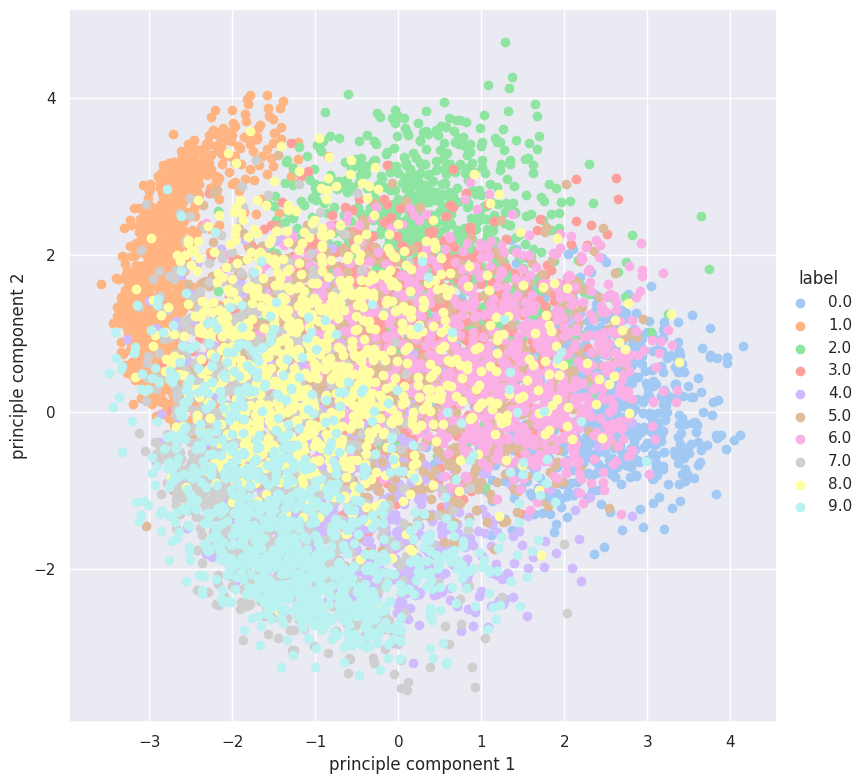

In [115]:
pca = PCA(n_components=2)
latent_features = zs_AE.cpu().detach().numpy()
pca.fit(latent_features)
latent_features = StandardScaler().fit_transform(latent_features)
columns = ["principle component 1", "principle component 2"]
features = pd.DataFrame(data = pca.transform(latent_features),
                        columns = columns)
features['label'] = labels_AE.cpu().detach().numpy()

with sns.color_palette("pastel"):
    sns.FacetGrid(features, hue="label", height=8, aspect=1).map(
        plt.scatter, columns[0], columns[1]).add_legend()

In [50]:

VAE_m = VAE_model.get_model()
VAE_m.eval()

# zs = torch.Tensor()
zs = torch.Tensor().cuda()
labels = torch.Tensor().cuda()

for i, (data, label) in enumerate(test_loader):
    data = data.to(device)
    label = label.to(device)

    recon_batch, mu, logvar = VAE_m(data)
    zs = torch.cat((zs, mu), 0)
    labels = torch.cat((labels, label), 0)

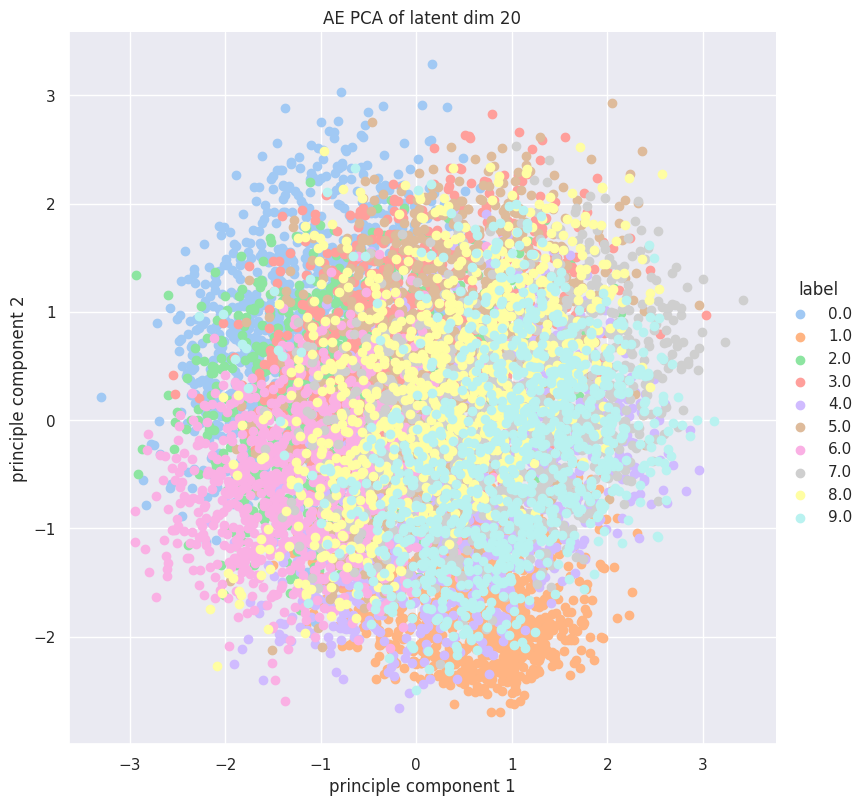

In [116]:
pca = PCA(n_components=2)
latent_features = zs.cpu().detach().numpy()
pca.fit(latent_features)
latent_features = StandardScaler().fit_transform(latent_features)
columns = ["principle component 1", "principle component 2"]
features = pd.DataFrame(data = pca.transform(latent_features),
                        columns = columns)
features['label'] = labels.cpu().detach().numpy()

with sns.color_palette("pastel"):
    sns.FacetGrid(features, hue="label", height=8, aspect=1).map(
        plt.scatter, columns[0], columns[1]).add_legend()
    plt.title('AE PCA of latent dim 20')

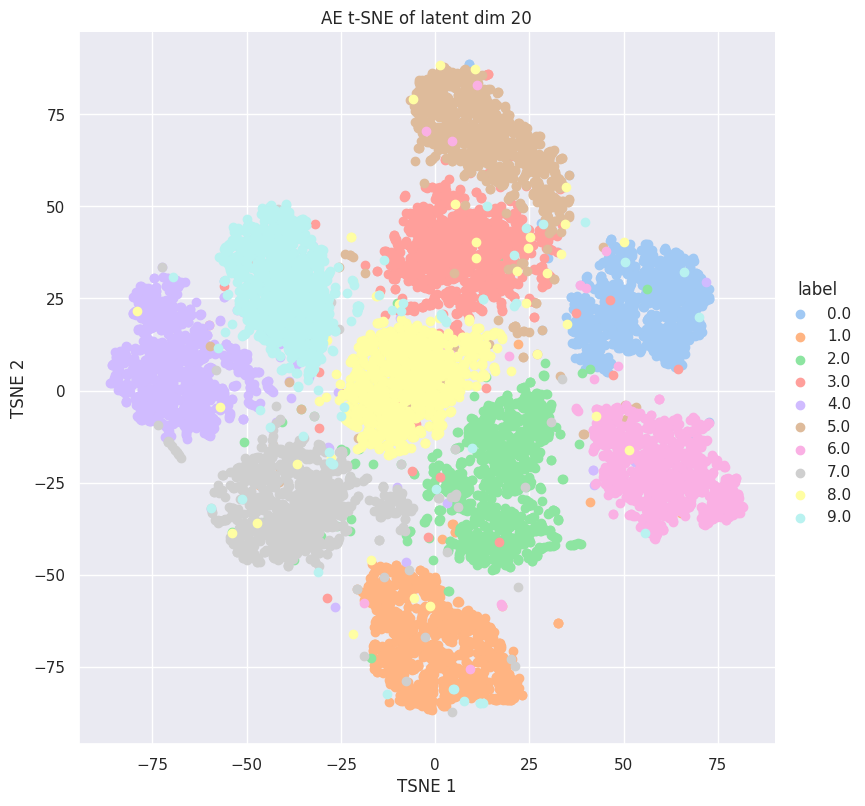

In [117]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=0)
projections = tsne.fit_transform(latent_features)
columns = ["TSNE 1", "TSNE 2"]
features_tsne = pd.DataFrame(data = projections, columns = columns)
features_tsne['label'] = labels.cpu().detach().numpy()
with sns.color_palette("pastel"):
    sns.FacetGrid(features_tsne, hue="label", height=8, aspect=1).map(
        plt.scatter, columns[0], columns[1]).add_legend()
    plt.title('AE t-SNE of latent dim 20')

In [121]:
def cal_PCA_TSNE(zs, labels):
    pca = PCA(n_components=2)
    latent_features = zs.cpu().detach().numpy()
    latent_features = StandardScaler().fit_transform(latent_features)

    pca.fit(latent_features)
    columns = ["principle component 1", "principle component 2"]
    features = pd.DataFrame(data = pca.transform(latent_features),
                        columns = columns)
    features['label'] = labels.cpu().detach().numpy()

    tsne = TSNE(n_components=2, random_state=0)
    projections = tsne.fit_transform(latent_features)
    columns = ["TSNE 1", "TSNE 2"]
    features_tsne = pd.DataFrame(data = projections, columns = columns)
    features_tsne['label'] = labels.cpu().detach().numpy()

    return features, features_tsne


In [122]:
f_PCA, f_TSNE = cal_PCA_TSNE(zs, labels)

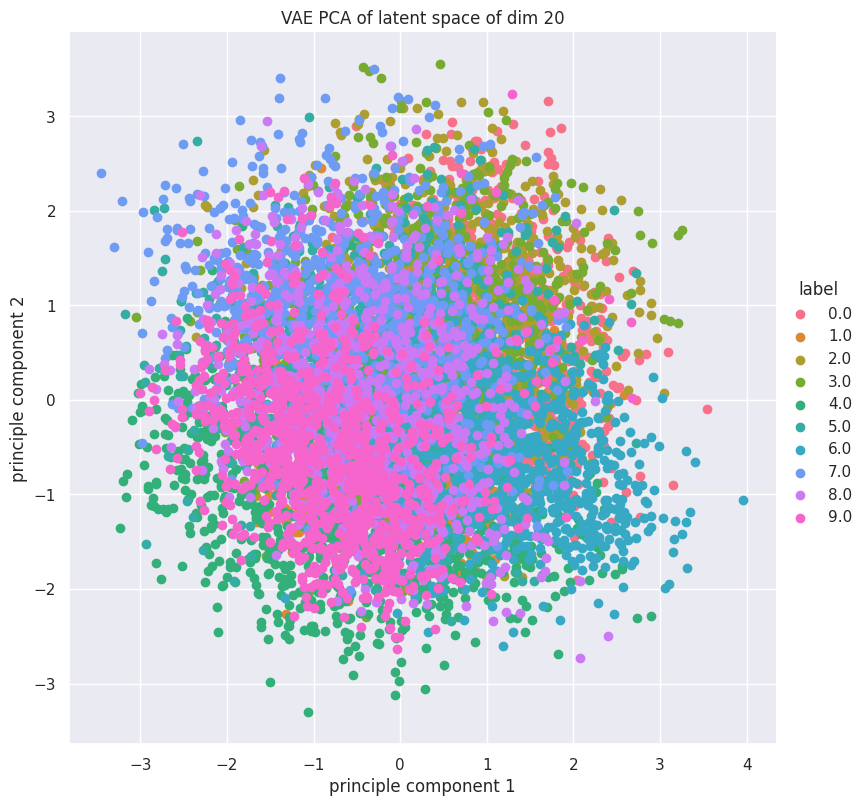

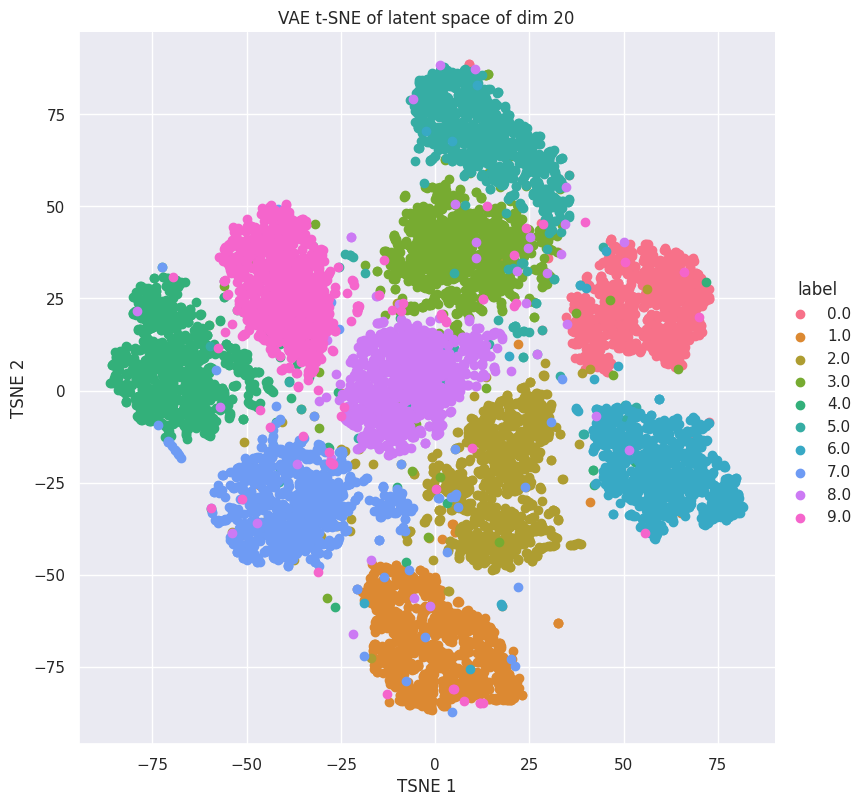

In [123]:
with sns.color_palette('husl',10):
    sns.FacetGrid(f_PCA, hue="label", height=8, aspect=1).map(
        plt.scatter, f_PCA.columns[0], f_PCA.columns[1]).add_legend()
    plt.title('VAE PCA of latent space of dim 20')

with sns.color_palette('husl',10):
    sns.FacetGrid(f_TSNE, hue="label", height=8, aspect=1).map(
        plt.scatter, f_TSNE.columns[0], f_TSNE.columns[1]).add_legend()
    plt.title('VAE t-SNE of latent space of dim 20')

VAE

In [ ]:
pca = PCA(n_components=2)
latent_features = zs.cpu().detach().numpy()
pca.fit(latent_features)
latent_features = StandardScaler().fit_transform(latent_features)
columns = ["principle component 1", "principle component 2"]
features = pd.DataFrame(data = pca.transform(latent_features),
                        columns = columns)
features['label'] = labels.cpu().detach().numpy()

with sns.color_palette('husl',10):
    sns.FacetGrid(features_tsne, hue="label", height=8, aspect=1).map(
        plt.scatter, columns[0], columns[1]).add_legend()
    plt.title('t-SNE of latent space of dim 20')

<ipython-input-57-be285ffb3326>:20: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  ax.figure.colorbar(scalarmap)


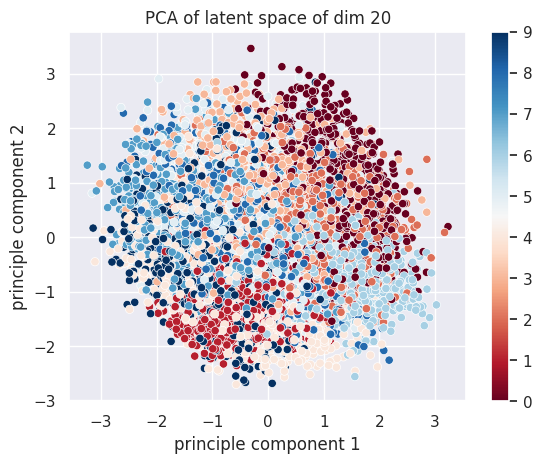

In [57]:
pca = PCA(n_components=2)
latent_features = zs.cpu().detach().numpy()
pca.fit(latent_features)
latent_features = StandardScaler().fit_transform(latent_features)
columns = ["principle component 1", "principle component 2"]
features = pd.DataFrame(data = pca.transform(latent_features),
                        columns = columns)
features['label'] = labels.cpu().detach().numpy()

sns.set()
ax = sns.scatterplot(x=columns[0], y=columns[1],
                     hue = 'label', palette='RdBu',
                     data=features)

norm = plt.Normalize(labels.min(), labels.max())
scalarmap = plt.cm.ScalarMappable(cmap="RdBu", norm=norm)
scalarmap.set_array([])

ax.get_legend().remove() # Remove the legend and add a colorbar
ax.figure.colorbar(scalarmap)

# set the title for the figure
plt.title('PCA of latent space of dim 20')
plt.show()

In [66]:
# !pip install umap-learn --quiet

In [65]:
# !pip uninstall UMAP -y

Found existing installation: umap 0.1.1
Uninstalling umap-0.1.1:
  Successfully uninstalled umap-0.1.1


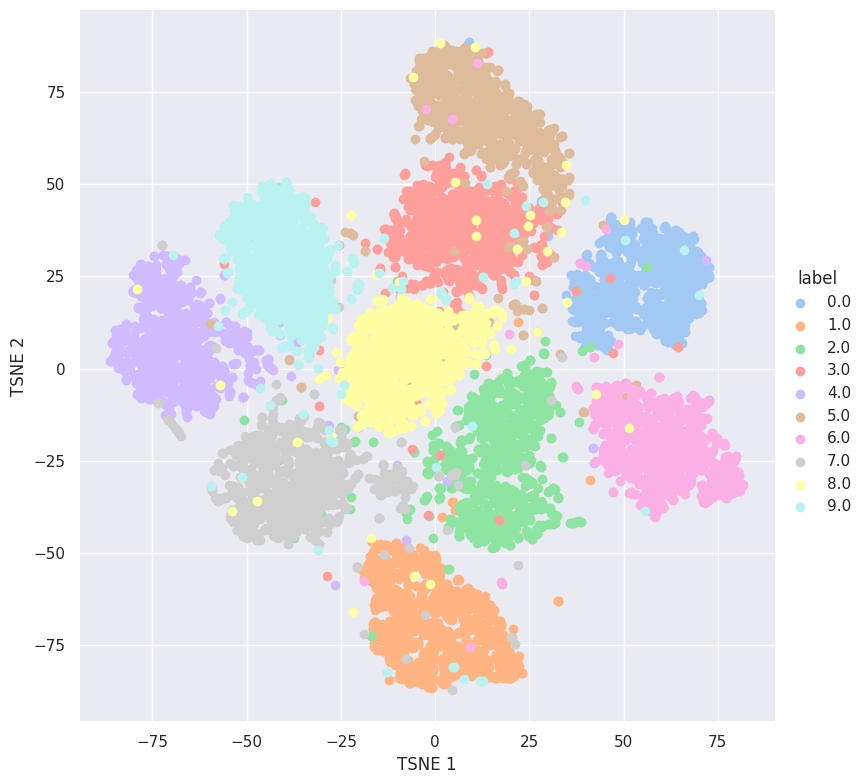

In [104]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=0)
projections = tsne.fit_transform(latent_features)
columns = ["TSNE 1", "TSNE 2"]
features_tsne = pd.DataFrame(data = projections, columns = columns)
features_tsne['label'] = labels.cpu().detach().numpy()
with sns.color_palette("pastel"):
    sns.FacetGrid(features_tsne, hue="label", height=8, aspect=1).map(
        plt.scatter, columns[0], columns[1]).add_legend()

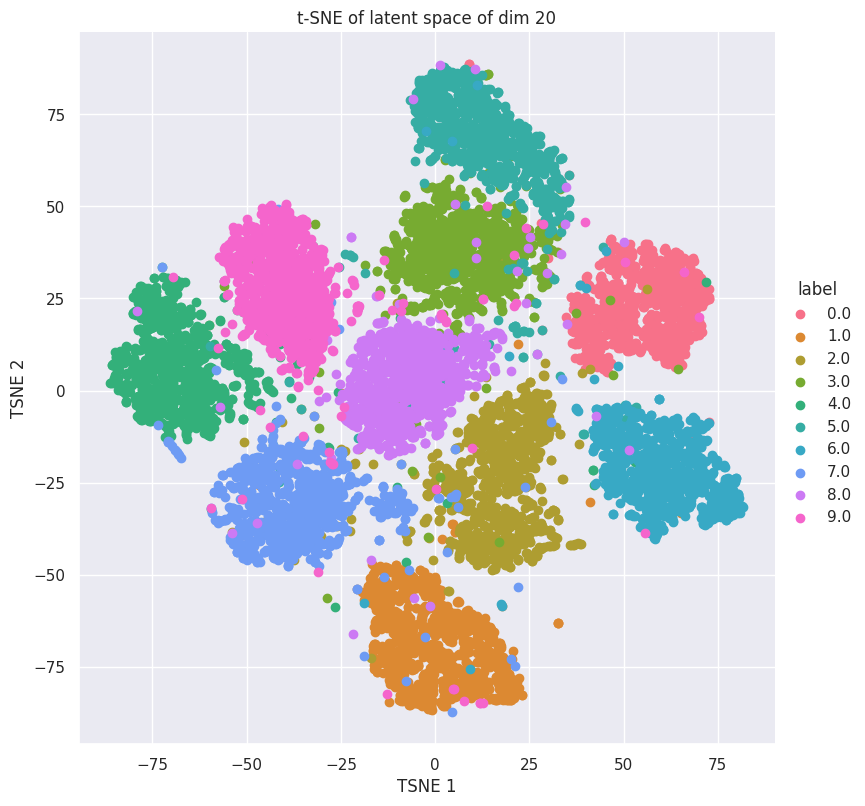

In [108]:
features_tsne = pd.DataFrame(data = projections, columns = columns)
features_tsne['label'] = labels.cpu().detach().numpy()
with sns.color_palette('husl',10):
    sns.FacetGrid(features_tsne, hue="label", height=8, aspect=1).map(
        plt.scatter, columns[0], columns[1]).add_legend()
    plt.title('t-SNE of latent space of dim 20')

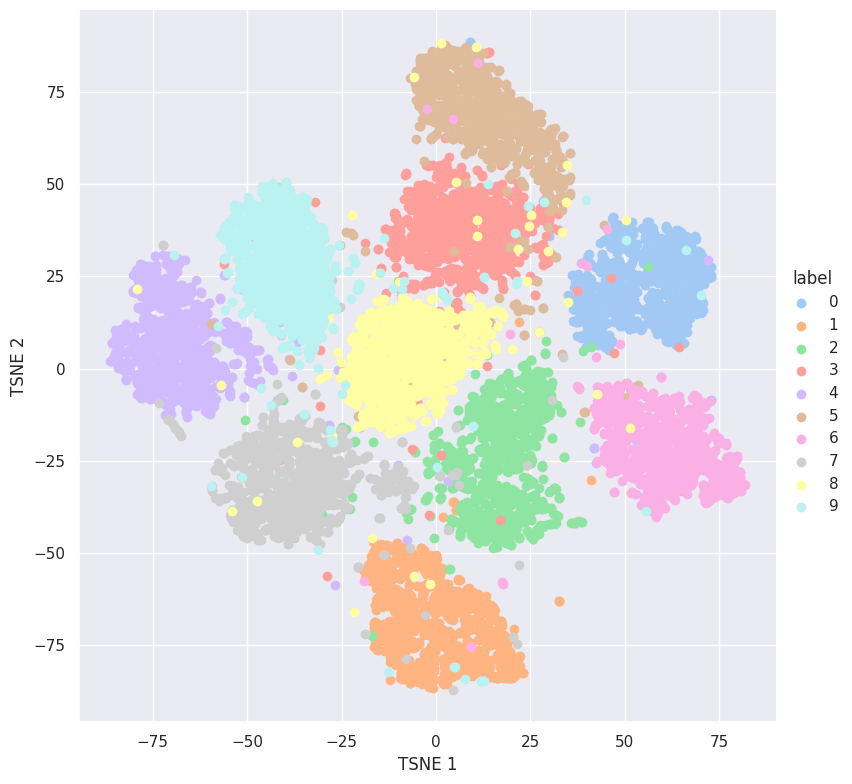

In [101]:
with sns.color_palette("pastel"):
    sns.FacetGrid(features, hue="label", height=8, aspect=1).map(
        plt.scatter, 'TSNE 1', 'TSNE 2').add_legend()

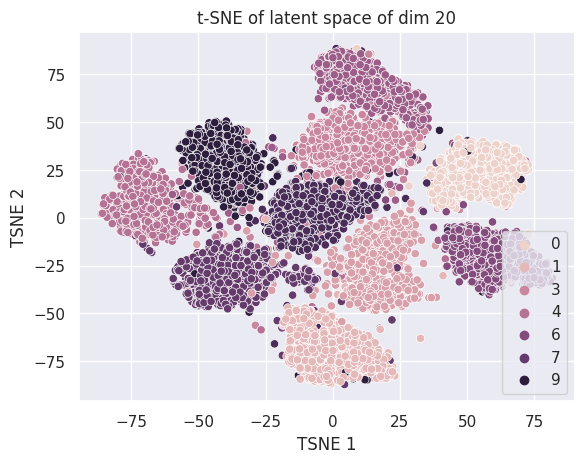

In [84]:
sns.set()
features['label'] = features['label'].astype('int')
ax = sns.scatterplot(x=columns[0], y=columns[1], hue='label',
                     data=features)
# norm = plt.Normalize(labels.min(), labels.max())
# ax.get_legend().remove() # Remove the legend and add a colorbar
# ax.figure.colorbar(scalarmap)
plt.legend(loc='lower right')
# set the title for the figure
plt.title('t-SNE of latent space of dim 20')
plt.show()

In [85]:
import seaborn.objects as so

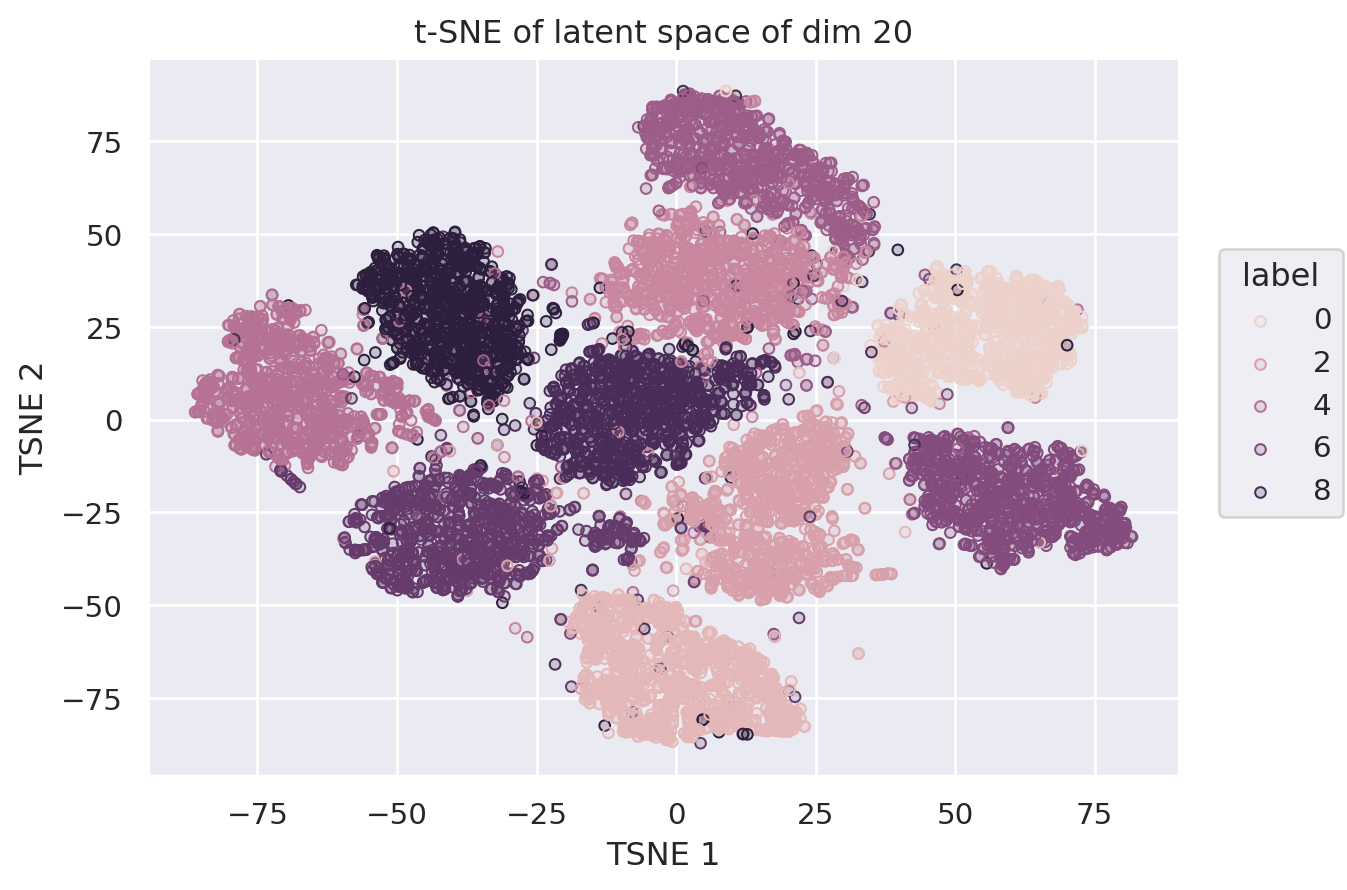

In [90]:
p = (so.Plot(features, x="TSNE 1", y="TSNE 2")
    .add(so.Dots(), color="label", size=0.4).scale(marker=['o','x']))
p.label(x="TSNE 1", y="TNSE 2", color="")
p.label(title='t-SNE of latent space of dim 20')